# All plots for ANC paper

This notebook produces all the plots that we include in the ANC manuscript (`docs/manuscript`)

Most plots can be generated locally with open source data.

Some plots require to be run on files local to the LIGO cluster. These scripts are included in  `ligo_cluster_scripts/` and noted in the below notebook.

# Setup 

In [4]:
from scipy.io import loadmat
import numpy as np 
from matplotlib import pyplot as plt
import scienceplots
plt.style.use('science')

# Section 2

## Senstivity Plot 

In [244]:
from gwpy.timeseries import TimeSeries
from matplotlib import pyplot as plt
import scienceplots
import pandas as pd 
import numpy as np 

plt.style.use('science')

#Example from https://gwpy.github.io/docs/latest/spectrum/

#Channels that we will plot the ASD of
L1_string = 'L1:DCS-CALIB_STRAIN_C01_AR'
H1_string = 'H1:DCS-CALIB_STRAIN_C01_AR'


#Setelct some times from the O3 segments
df = pd.read_csv('../../data/L1-O3a-segments.csv',header=None)
i = 0
t0 = df.iloc[i][0]
t1 = t0 + (10*60)#10 mins later


#Get the data
print("get the data")
gwdata_L1   = TimeSeries.get(L1_string,start=t0, end=t1,host='losc-nds.ligo.org')
spectrum_L1 = gwdata_L1.asd(8, 4) #Welch method. Also used in GWPy example

print("get data 2")
gwdata_H1   = TimeSeries.get(H1_string,start=t0, end=t1,host='losc-nds.ligo.org')
spectrum_H1 = gwdata_H1.asd(8, 4) #Welch method. Also used in GWPy example


freqs_L1 = np.arange(len(spectrum_L1))*spectrum_L1.df
asd_L1 = np.array(spectrum_L1)

freqs_H1 = np.arange(len(spectrum_H1))*spectrum_H1.df
asd_H1 = np.array(spectrum_H1)

get the data
get data 2


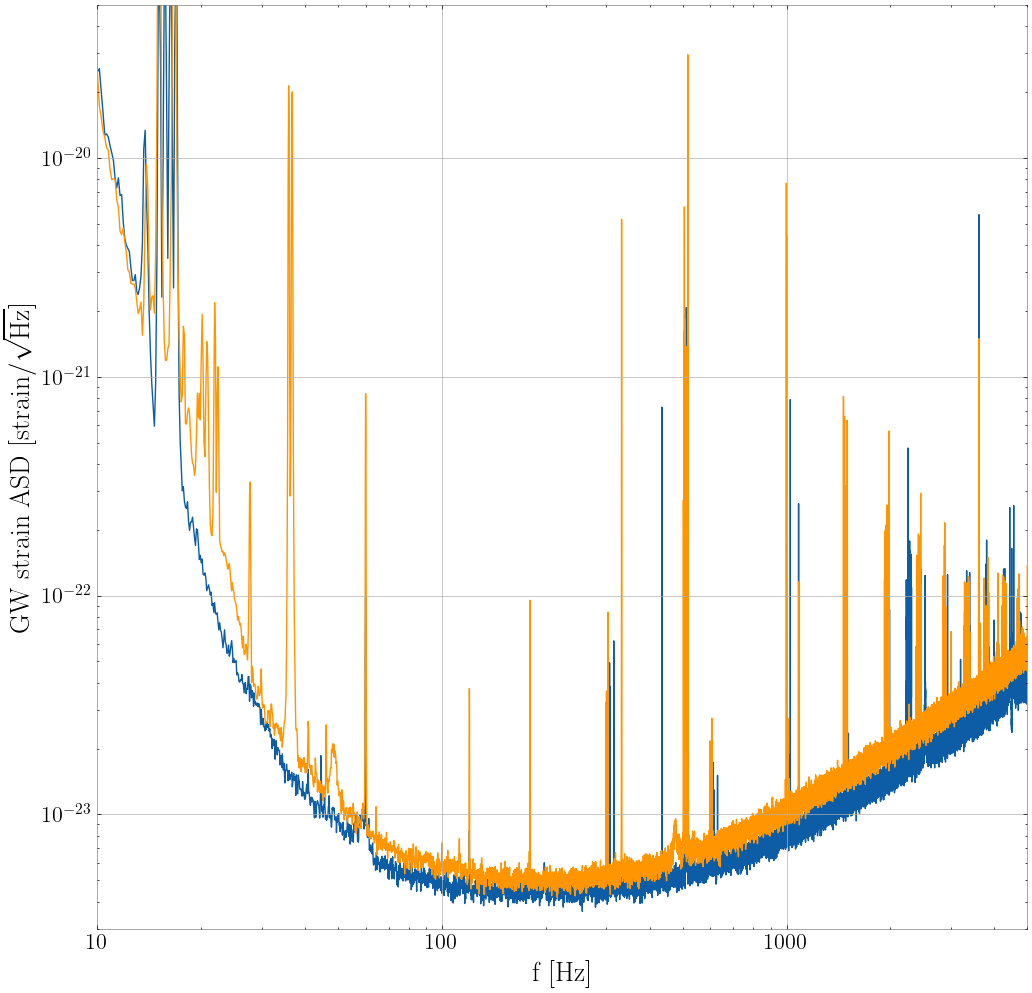

In [245]:



from matplotlib import pyplot as plt
import scienceplots
import glob
import numpy as np
plt.style.use('science')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),sharex=False)

ax.plot(freqs_L1,asd_L1,c="C0")
ax.plot(freqs_H1,asd_H1,c="C2")



ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, 5000)
ax.set_ylim(3e-24, 5e-20)


fs = 20
ax.set_ylabel(r'GW strain ASD [strain$/\sqrt{\mathrm{Hz}}$]',fontsize=fs)
ax.set_xlabel(r'f [Hz]',fontsize=fs)


ax.axes.tick_params(axis="both", labelsize=fs-4)



plt.savefig('../../data/manuscript_images/sensitivity_sq2.png',bbox_inches='tight',dpi=300)



## Coherence plot

The two coherence plots (the stacked PEMs and the spectrogram) are both produced using local LIGO data.

Stacked pem plot is produced by `get_pem_data.py`

Spectrogram is produced by `coherence_spectrogram.py`

These scripts need to be run on the LIGO cluster. 


In [6]:
import pandas as pd 
from gwpy.timeseries import TimeSeries
L1_string = 'L1:DCS-CALIB_STRAIN_C01_AR' #strain channel

pem_channels = ['L1:PEM-CS_MAINSMON_EBAY_1_DQ',   
                 'L1:PEM-CS_MAINSMON_EBAY_2_DQ',
                 'L1:PEM-CS_MAINSMON_EBAY_3_DQ',
                 'L1:PEM-CS_MIC_LVEA_INPUTOPTICS_DQ',
                 'L1:PEM-EY_ACC_BEAMTUBE_MAN_Y_DQ',
                 'L1:PEM-EY_MAINSMON_EBAY_1_DQ',
                 'L1:PEM-EY_MIC_VEA_PLUSY_DQ',
                 'L1:PEM-EY_VAULT_MAG_LEMI_X_DQ',
                 'L1:PEM-EY_VAULT_MAG_LEMI_Y_DQ'
]


#Select some times from the O3 segments
df = pd.read_csv('../../data/L1-O3a-segments.csv',header=None)
i = 0
t0 = df.iloc[i][0]
t1 = t0 + (10*60)# 10 mins later


#Load the strain data
hoft   = TimeSeries.get(L1_string,start=t0, end=t1,host='losc-nds.ligo.org')


## Cascade plot 

Modified version of https://git.ligo.org/hannah.middleton/anc/-/blob/master/code/plottingScripts/powerCascade/2dPowerCascade.py


This is a little bit involved and proceeds as follows:


1. Find some uninterrupted segments of PEM data in the open source, for channel `H1:PEM-CS_MAINSMON_EBAY_1_DQ`
2. We manually select the start time. We choose 1265852907 which has a total segment length of 86168 s
3. Grab that data and save it to disk.
4. Batch it and save batches to disk








I'm sure there is a more efficient way to do this....


In [1]:
### STEP 1

#First lets find some times with uninterrupted segments of data

from gwpy.detector import ChannelList, Channel
server = 'losc-nds.ligo.org'  #-- GWOSC NDS2 server name

chanlist = ChannelList.query_nds2('*', host='losc-nds.ligo.org' )
auxlist = ['H1:PEM-CS_MAINSMON_EBAY_1_DQ']
day = 60*60*24   #1 day in seconds
t0  = 1264316116 #time of GW200129_065458
end_time = t0+30*day #30 days later


batchSize = 64*5 #how long a single line is 
numplots = 210  #how many lines we want in the cascade plot
print(batchSize*numplots)


available = chanlist.query_nds2_availability(auxlist, t0, end_time, host=server)
segments = available['H1:PEM-CS_MAINSMON_EBAY_1_DQ']
for i in range(len(segments)):
   segment_length = segments[i][1]-segments[i][0]
   if segment_length > batchSize*numplots:
       print(i,segments[i][0],segments[i][1],segments[i][1]-segments[i][0])

67200
12 1264597197 1264703538 106341
33 1265243668 1265318151 74483
59 1265852907 1265939075 86168
72 1266280137 1266359523 79386
73 1266362166 1266436886 74720
74 1266446637 1266515968 69331


In [2]:
### STEP 2
from gwpy.timeseries import TimeSeries

#Get the data
referenceChannelName = 'H1:PEM-CS_MAINSMON_EBAY_1_DQ'
start_time = 1265852907

end_time = start_time + batchSize*numplots
reference   = TimeSeries.get(referenceChannelName,start=start_time, end=end_time,host=server)


In [5]:
#Save it 
reference.write(f'../../data/cascade_H1_file_o3_canonical.txt')


#Load it again
nr = TimeSeries.read(f'../../data/cascade_H1_file_o3_canonical.txt')

In [6]:
### STEP 4
import numpy as np 
#Chop it up into batches and save to disk
reference_np = np.array(nr)
times_np = np.array(nr.times)

split_arrays = np.split(reference_np,numplots)
split_array_times = np.split(times_np,numplots)

In [8]:
for i in range(len(split_arrays)):
    ts_i = TimeSeries(split_arrays[i], unit=reference.unit,sample_rate=reference.sample_rate,times=split_array_times[i])
    ts_i.write(f'../../data/cascade_H1_canonical/H1_{i}.txt')


In [9]:
from gwpy.timeseries import TimeSeries
import matplotlib .pyplot as plt 
import matplotlib as mpl

def read_and_plot(file_path):
    #print ("Reading: ", file_path)
    reference   = TimeSeries.read(file_path)

    #Get the ASD
    refASD = reference.asd()
   
    #Some parameter defns
    fLimLow  = 59.5
    fLimHigh = 60.5


    fstart = refASD.f0.value
    fend = len(refASD.value)*refASD.df.value
    fstep = refASD.df.value
   
    fs = np.arange(fstart,fend,fstep)

    indexLow  = int( fLimLow / fstep )+1
    indexHigh = int( fLimHigh/ fstep )

    val = refASD.value
    return fs[indexLow:indexHigh], val[indexLow:indexHigh]



def offset(myFig,myAx,n=1):
    #shift = yOff / myFig.dpi
    #dx, dy = 0., shift

    shift = 0.02
    dx, dy = 0., shift
    return (myAx.transData + mpl.transforms.ScaledTranslation(dx,n*dy,myFig.dpi_scale_trans)), shift



In [10]:
import re

#natural sorting e.g. https://stackoverflow.com/questions/5967500/how-to-correctly-sort-a-string-with-a-number-inside
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


In [11]:
import glob
import scienceplots
from scipy.signal import peak_widths
from scipy.interpolate import interp1d



def index_to_xdata(xdata, indices):
    "interpolate the values from signal.peak_widths to xdata"
    ind = np.arange(len(xdata))
    f = interp1d(ind,xdata)
    return f(indices)






plt.style.use('science')

list_of_cascade_files = glob.glob('../../data/cascade_H1_O3/*')
list_of_cascade_files.sort(key=natural_keys)

#setup the figure
fig, ax = plt.subplots(figsize=(8,10))

#How many batches to plot?
num_to_plot = len(list_of_cascade_files)

ymin = +1e3
ymax = -1e3
peaks = np.zeros(num_to_plot)
FWHMs = np.zeros(num_to_plot)
for i in range(num_to_plot):

    #Load the data
    f = list_of_cascade_files[i]
    xs, ys = read_and_plot(f)
    log10ys = np.log10(ys)

    #Shift, log and plot it
    shift= 0.6
    yplot = log10ys+shift*i
  
    
    #Surface some numbers
    idx = np.argmax(ys) #index of maximum
    peaks[i] = xs[idx]
    
    #https://stackoverflow.com/questions/66464148/peak-widths-w-r-t-to-x-axis
    results = peak_widths(ys, [idx], rel_height=0.5)

    
 
    df = np.diff(xs)[0] #this is the same spacing between every sample
    width_in_samples = results[0][0]
    width_in_hz = width_in_samples*df


    FWHMs[i] = width_in_hz*1e3 
   
    #Plot it 
    ax.plot(xs,yplot,color='k')
    #trans, shift = offset(fig,ax,i)
    #zInd = num_to_plot - i
    #ax.plot(xs,log10ys+shift*i,color='k',linewidth=0.5, zorder = zInd)

   

    if min(yplot) < ymin:
        ymin = min(yplot)
    if max(yplot) > ymax:
        ymax = max(yplot)

    #ax.plot(xs,log10ys+shift*i,color='k',linewidth=0.5, transform = trans)



#Config figure 

ax.set_xlim(59.5, 60.5)
fs=20
ax.set_xlabel('Frequency (Hz)',fontsize=fs)
ax.axes.tick_params(axis="both", labelsize=fs-4)

ax.grid(False)

for side in ["top", "right", "left"]:
    ax.spines[side].set_visible(False)

plt.tick_params(axis='x', which='both',top=False)
ax.set_yticks([])
ax.set_ylim(ymin, ymax)

plt.savefig('../../data/images/new_cascade_O3_new',bbox_inches='tight',dpi=300)



print (f"The peak of the ASD varies from {np.min(peaks)} to {np.max(peaks)} Hz, with an average value of {np.mean(peaks)} Hz")

print (f"The FWHM varies from {np.min(FWHMs)} to {np.max(FWHMs)} mHz, with an average value of {np.mean(FWHMs)} mHz")
 


The peak of the ASD varies from 59.96875 to 60.053125 Hz, with an average value of 60.00400297619048 Hz
The FWHM varies from 5.293773141356687 to 29.37747080651693 mHz, with an average value of 10.748538587464264 mHz


# Section 4



### Fourier response of data before/after filtering 

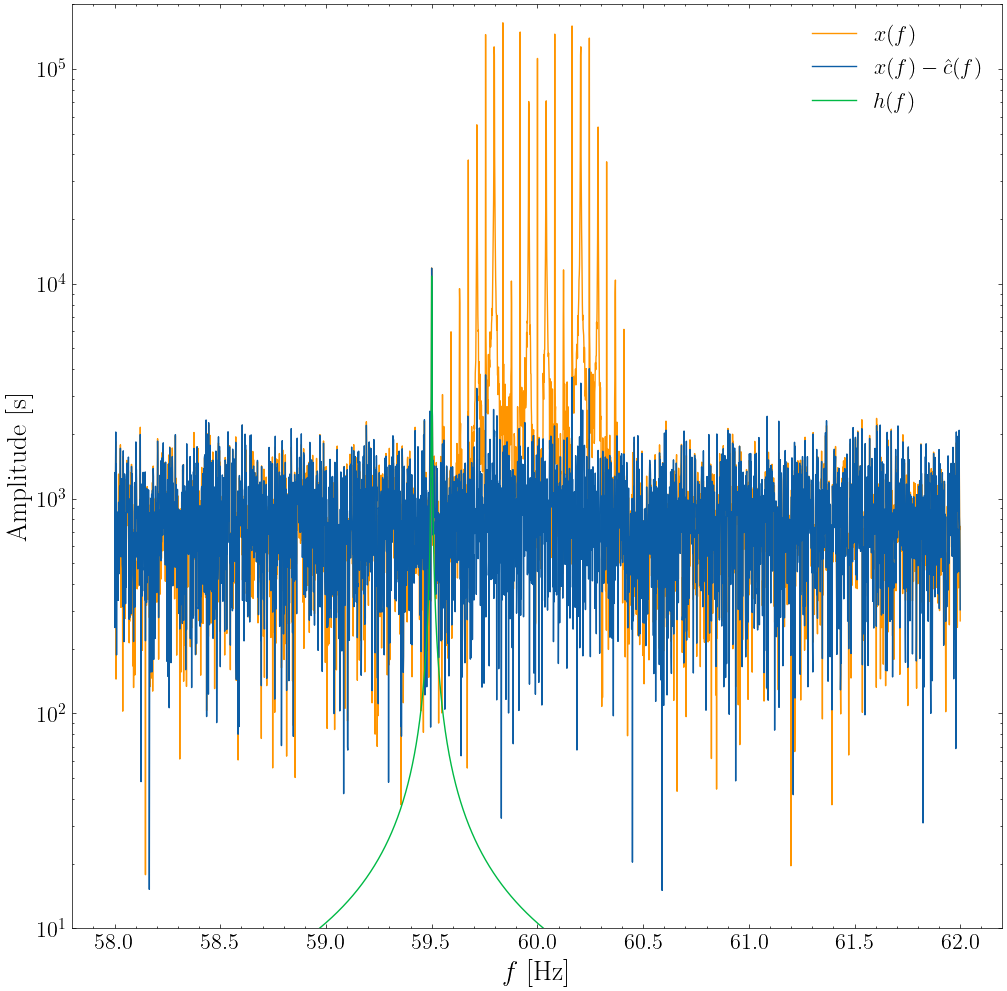

In [2]:
from scipy.io import loadmat
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use('science')


#Load the data
#Source: https://app.sparkmailapp.com/web-share/nn7zSvj6th64TsBkGfR-kPEs12nP-xkIdADR85Lj
data = loadmat("../../data/fig_spectrum.mat")

C = data['C'].flatten()
Q = data['Q'].flatten()
S = data['S'].flatten()
w = data['w'].flatten() #frequencies



fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),sharex=False)

ax.plot(w,S,label=r'$x(f)$',c='C2')
ax.plot(w,C,label=r'$x(f) - \hat{c}(f)$',c='C0')
ax.plot(w,Q,label=r'$h(f)$',c='C1')

# ax.plot(w,Q,label="GW signal")
# ax.plot(w,S,label="Primary signal")
# ax.plot(w,C,label="Filtered signal")



fs = 20
ax.set_ylabel(r'Amplitude [s]',fontsize=fs)
ax.set_xlabel(r'$f$ [Hz]',fontsize=fs)


ax.set_yscale('log')
ax.axes.tick_params(axis="both", labelsize=fs-4)

ax.legend(fontsize=fs-4)

ax.set_ylim(1e1,2e5)

plt.savefig('../../data/images/spectrum',bbox_inches='tight',dpi=300)
plt.show()




### 2D Viterbi tracking plots 

In [90]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes





def mean_squared_error(data_true,data_predict):
    MSE = np.square(np.subtract(data_true,data_predict)).mean()
    return MSE


def rmse(data_true,data_predict):

    difference = np.subtract(data_true,data_predict)
    squared_sum = np.sum(difference**2)


    
    return np.sqrt(squared_sum / len(data_true))



def load_data(path):

    data = loadmat(path)


    viterbi_with_pem = data['Y'] #Viterbi input matrix with PEM and GW. (131, 50)
    viterbi_without_pem = data['y'] # Viterbi input matrix with PEM cancelled #(131, 50)
    f = data['w0'].flatten()
    t = data['time'].flatten()


    GW_freq_true  = data['fq'].flatten()
    GW_freq_estim  = data['fhat_RLS'].flatten() #estimated GW frequency (with Viterbi) after the ANC

    return viterbi_with_pem,viterbi_without_pem,f,t,GW_freq_true,GW_freq_estim






def plot_2d(xbefore,xafter,f,t,GW_f_true1,GW_f_estim1,GW_f_true2,GW_f_estim2,vmin,vmax,fname=None,reverse_ordering=False,cmap='viridis'):

    #Plot figure
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17,9),sharey=True)


    pos1 = ax1.imshow(xbefore, cmap=cmap, interpolation='nearest',vmin=vmin,vmax=vmax,extent=[f[0],f[-1],t[0],t[-1]],aspect=1/200,alpha=0.9)
    pos2 = ax2.imshow(xafter, cmap=cmap, interpolation='nearest',vmin=vmin,vmax=vmax,extent=[f[0],f[-1],t[0],t[-1]],aspect=1/200,alpha=0.9)

    
    lw = 2.0
    ls = '--'

    # manually reverse the ordering since it should go the other way around according to Sofia
    if reverse_ordering:
        GW_f_true1 = GW_f_true1[::-1] 
        GW_f_estim1 = GW_f_estim1[::-1] 


        GW_f_true2 = GW_f_true2[::-1] 
        GW_f_estim2 = GW_f_estim2[::-1] 



    #Plot the true GW frequencies on LHS
    ax1.plot(GW_f_true1,t,c='C2',linewidth=lw,linestyle='solid')
    ax1.plot(GW_f_true2,t,c='C1',linewidth=lw,linestyle='solid')

    ax1.scatter(GW_f_true1,t,c='C2')
    ax1.scatter(GW_f_true2,t,c='C1')

    #Plot true GW freqs on RHS
    ax2.plot(GW_f_true1,t,c='C2',linewidth=lw,linestyle='solid')
    ax2.plot(GW_f_true2,t,c='C1',linewidth=lw,linestyle='solid')

    ax2.scatter(GW_f_true1,t,c='C2')
    ax2.scatter(GW_f_true2,t,c='C1')


    #Plot estimates on RHS    
    ax2.plot(GW_f_estim1,t,c='white',linewidth=lw,linestyle='dashed')
    ax2.plot(GW_f_estim2,t,c='white',linewidth=lw,linestyle='dashed')


    #Surface some error estimates
    MSE_low_noise = rmse(GW_f_true1,GW_f_estim1)
    MSE_high_noise = rmse(GW_f_true2,GW_f_estim2)

    print("Mean squared error in the frequency is:")
    print('RMSE, low noise:', MSE_low_noise)
    print('RMSe, high noise:', MSE_high_noise)






    fs = 20
    ax1.set_ylabel(r'Time [s]',fontsize=fs)
    ax1.set_xlabel(r'$f$ [Hz]',fontsize=fs)
    ax2.set_xlabel(r'$f$ [Hz]',fontsize=fs)

    ax1.axes.tick_params(axis="both", labelsize=fs-4)
    ax2.axes.tick_params(axis="both", labelsize=fs-4)


    plt.subplots_adjust(wspace=0.01)
    #ax2.spines['left'].set_color('white')


    axins = inset_axes(ax2, width = "5%", height = "100%", loc = 'lower left',
                       bbox_to_anchor = (1.02, 0., 1, 1), bbox_transform = ax2.transAxes,
                       borderpad = 0)
    fig.colorbar(pos2, cax = axins)

    axins.axes.tick_params(axis="both", labelsize=fs-4)
    axins.axes.set_ylabel(r'$ \left |\mathcal{F} \left[ x(t)\right] \right|^2$',rotation=0,fontsize=fs,labelpad=15)


    ax1.set_xlim(f[0],f[-1])
    ax1.set_ylim(t[0],t[-1])
    ax2.set_xlim(f[0],f[-1])
    ax2.set_ylim(t[0],t[-1])


    if fname is not None:
       plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)




    plt.show()








In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes





def mean_squared_error(data_true,data_predict):
    MSE = np.square(np.subtract(data_true,data_predict)).mean()
    return MSE


def rmse(data_true,data_predict):

    difference = np.subtract(data_true,data_predict)
    squared_sum = np.sum(difference**2)


    
    return np.sqrt(squared_sum / len(data_true))



def load_data(path):

    data = loadmat(path)


    viterbi_with_pem = data['Y'] #Viterbi input matrix with PEM and GW. (131, 50)
    viterbi_without_pem = data['y'] # Viterbi input matrix with PEM cancelled #(131, 50)
    f = data['w0'].flatten()
    t = data['time'].flatten()


    GW_freq_true  = data['fq'].flatten()
    GW_freq_estim  = data['fhat_RLS'].flatten() #estimated GW frequency (with Viterbi) after the ANC

    return viterbi_with_pem,viterbi_without_pem,f,t,GW_freq_true,GW_freq_estim






def plot_2d2(xbefore,xafter,f,t,GW_f_true1,GW_f_estim1,GW_f_true2,GW_f_estim2,vmin,vmax,fname=None,reverse_ordering=False,cmap='viridis'):

    #Plot figure
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17,9),sharey=True)


    pos1 = ax1.imshow(xbefore, cmap=cmap, interpolation='nearest',vmin=vmin,vmax=vmax,extent=[f[0],f[-1],t[0],t[-1]],aspect=1/200,alpha=0.9)
    pos2 = ax2.imshow(xafter, cmap=cmap, interpolation='nearest',vmin=vmin,vmax=vmax,extent=[f[0],f[-1],t[0],t[-1]],aspect=1/200,alpha=0.9)

    
    lw = 2.0
    ls = '--'

    # manually reverse the ordering since it should go the other way around according to Sofia
    if reverse_ordering:
        GW_f_true1 = GW_f_true1[::-1] 
        GW_f_estim1 = GW_f_estim1[::-1] 


        GW_f_true2 = GW_f_true2[::-1] 
        GW_f_estim2 = GW_f_estim2[::-1] 



    #Plot the true GW frequencies on LHS
    ax1.plot(GW_f_true1,t,c='C2',linewidth=lw,linestyle='solid')
    ax1.plot(GW_f_true2,t,c='C1',linewidth=lw,linestyle='solid')

    ax1.scatter(GW_f_true1,t,c='C2')
    ax1.scatter(GW_f_true2,t,c='C1')

    #Plot true GW freqs on RHS
    ax2.plot(GW_f_true1,t,c='C2',linewidth=lw,linestyle='solid')
    ax2.plot(GW_f_true2,t,c='C1',linewidth=lw,linestyle='solid')

    ax2.scatter(GW_f_true1,t,c='C2')
    ax2.scatter(GW_f_true2,t,c='C1')


    #Plot estimates on RHS    
    ax2.plot(GW_f_estim1,t,c='white',linewidth=lw,linestyle='dashed')
    ax2.plot(GW_f_estim2,t,c='white',linewidth=lw,linestyle='dashed')


    #Surface some error estimates
    MSE_low_noise = rmse(GW_f_true1,GW_f_estim1)
    MSE_high_noise = rmse(GW_f_true2,GW_f_estim2)

    print("Mean squared error in the frequency is:")
    print('RMSE, low noise:', MSE_low_noise)
    print('RMSe, high noise:', MSE_high_noise)






    fs = 20
    ax1.set_ylabel(r'Time [s]',fontsize=fs)
    ax1.set_xlabel(r'$f$ [Hz]',fontsize=fs)
    ax2.set_xlabel(r'$f$ [Hz]',fontsize=fs)

    ax1.axes.tick_params(axis="both", labelsize=fs-4)
    ax2.axes.tick_params(axis="both", labelsize=fs-4)


    plt.subplots_adjust(wspace=0.01)
    #ax2.spines['left'].set_color('white')


    axins = inset_axes(ax2, width = "5%", height = "100%", loc = 'lower left',
                       bbox_to_anchor = (1.02, 0., 1, 1), bbox_transform = ax2.transAxes,
                       borderpad = 0)
    fig.colorbar(pos2, cax = axins)

    axins.axes.tick_params(axis="both", labelsize=fs-4)
    axins.axes.set_ylabel(r'$ \left |\mathcal{F} \left[ x(t)\right] \right|^2$',rotation=0,fontsize=fs,labelpad=15)
    axins.yaxis.set_major_locator(plt.MaxNLocator(5))

    ax1.set_xlim(f[0],f[-1])
    ax1.set_ylim(t[0],t[-1])
    ax2.set_xlim(f[0],f[-1])
    ax2.set_ylim(t[0],t[-1])


    if fname is not None:
       plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)




    plt.show()








Mean squared error in the frequency is:
RMSE, low noise: 0.0375727306402589
RMSe, high noise: 0.47308146292856423


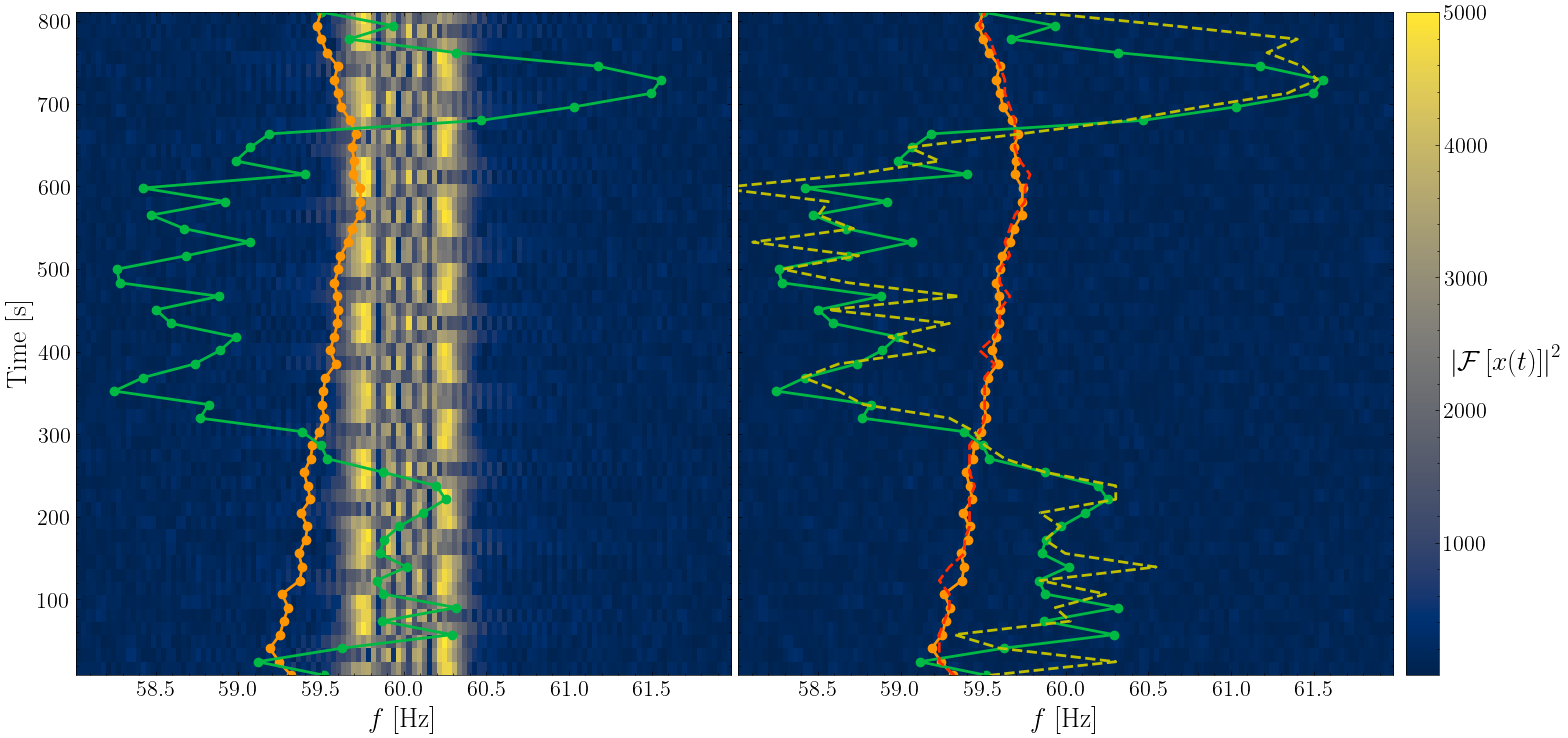

In [5]:
path1 = "../../data/fig_plot_8_and_9_viterbi_path_ANC_example_1.mat"
viterbi_with_pem,viterbi_without_pem,f,t,GW_freq_true1,GW_freq_estim1 = load_data(path1)


path2 = "../../data/fig_plot_8_and_9_viterbi_path_ANC_example_2.mat"
_,_,_,_,GW_freq_true2,GW_freq_estim2 = load_data(path2)



##Low contrast
cbar_lower_limit = 1
cbar_upper_limit = 5000
plot_2d(viterbi_with_pem.T,viterbi_without_pem.T,f,t,GW_freq_true1,GW_freq_estim1,GW_freq_true2,GW_freq_estim2,cbar_lower_limit,cbar_upper_limit,fname='viterbi_tracking_canonical',reverse_ordering=True,cmap='cividis')

Mean squared error in the frequency is:
RMSE, low noise: 0.0375727306402589
RMSe, high noise: 0.47308146292856423


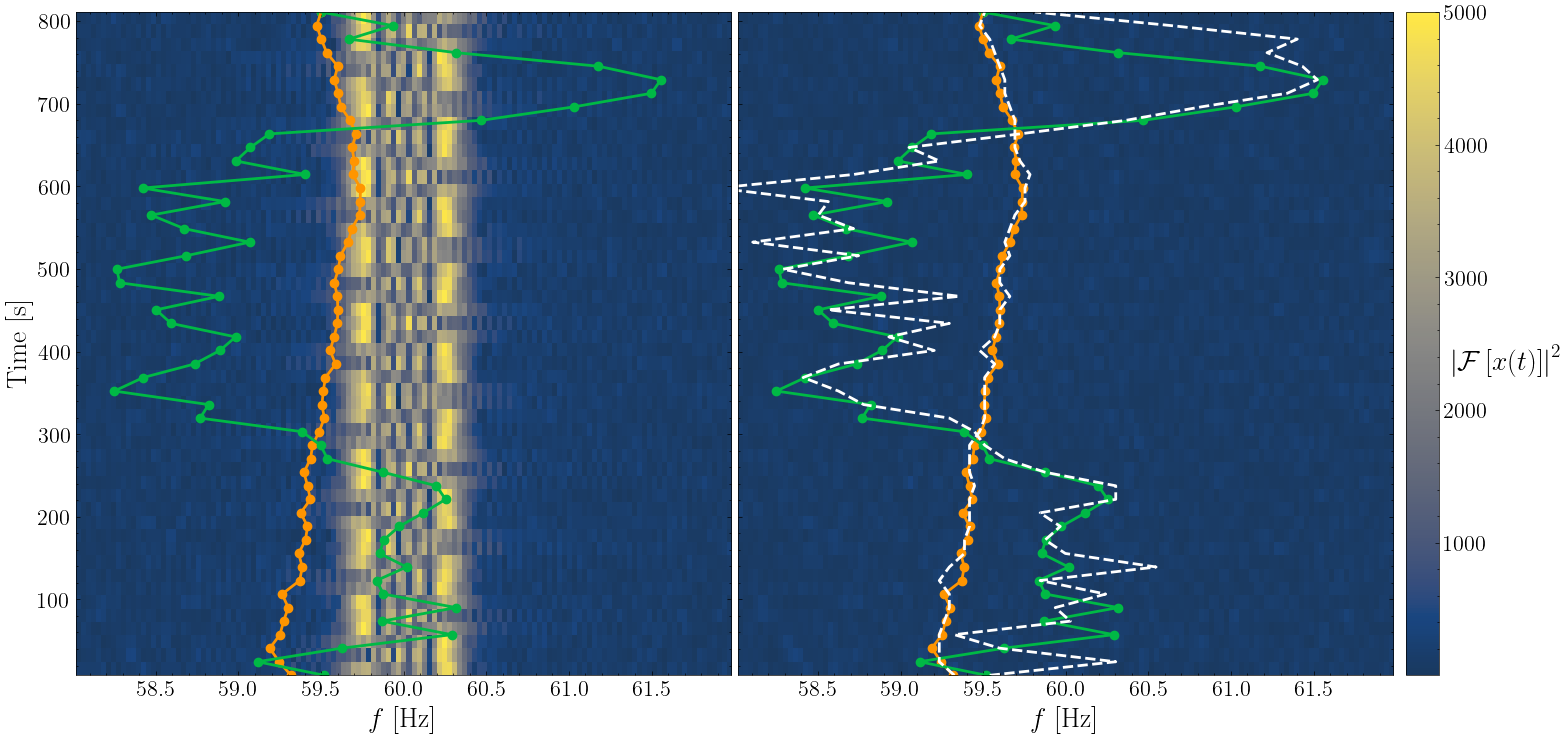

In [99]:
path1 = "../../data/fig_plot_8_and_9_viterbi_path_ANC_example_1.mat"
viterbi_with_pem,viterbi_without_pem,f,t,GW_freq_true1,GW_freq_estim1 = load_data(path1)


path2 = "../../data/fig_plot_8_and_9_viterbi_path_ANC_example_2.mat"
_,_,_,_,GW_freq_true2,GW_freq_estim2 = load_data(path2)



##Low contrast
cbar_lower_limit = 1
cbar_upper_limit = 5000
plot_2d(viterbi_with_pem.T,viterbi_without_pem.T,f,t,GW_freq_true1,GW_freq_estim1,GW_freq_true2,GW_freq_estim2,cbar_lower_limit,cbar_upper_limit,fname='viterbi_tracking_canonical',reverse_ordering=True,cmap='cividis')

Mean squared error in the frequency is:
RMSE, low noise: 0.0375727306402589
RMSe, high noise: 0.47308146292856423


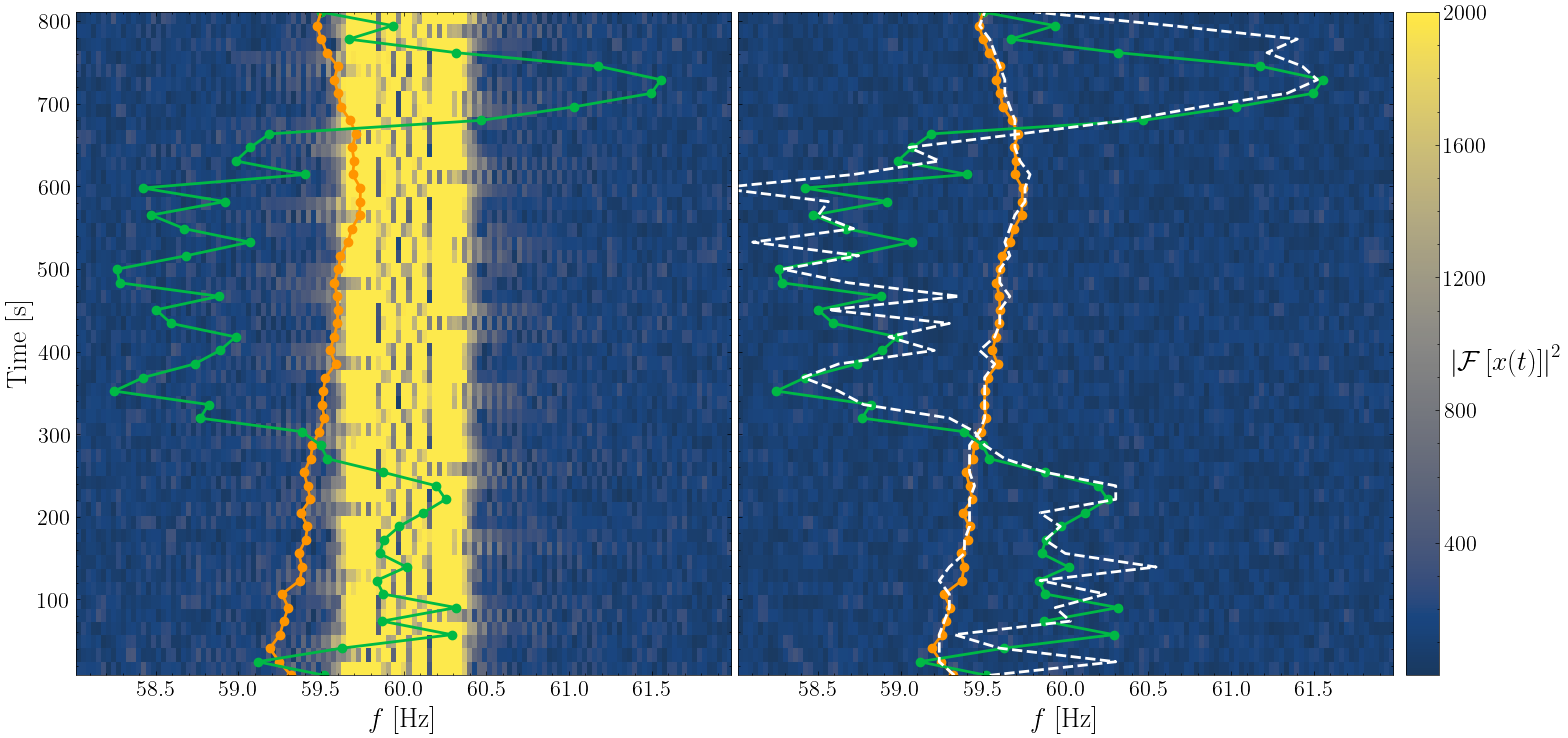

In [9]:
path1 = "../../data/fig_plot_8_and_9_viterbi_path_ANC_example_1.mat"
viterbi_with_pem,viterbi_without_pem,f,t,GW_freq_true1,GW_freq_estim1 = load_data(path1)


path2 = "../../data/fig_plot_8_and_9_viterbi_path_ANC_example_2.mat"
_,_,_,_,GW_freq_true2,GW_freq_estim2 = load_data(path2)



##Low contrast
cbar_lower_limit = 1
cbar_upper_limit = 2000
plot_2d2(viterbi_with_pem.T,viterbi_without_pem.T,f,t,GW_freq_true1,GW_freq_estim1,GW_freq_true2,GW_freq_estim2,cbar_lower_limit,cbar_upper_limit,fname='viterbi_tracking_canonical',reverse_ordering=True,cmap='cividis')

# Section 5 A 

['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']
$\Delta f_{\rm ac}$
D_a 0.5 0.5
D_a 1.0 0.5
D_a 1.5 0.57
$\sigma_{\theta}^2$


NameError: name 'np' is not defined

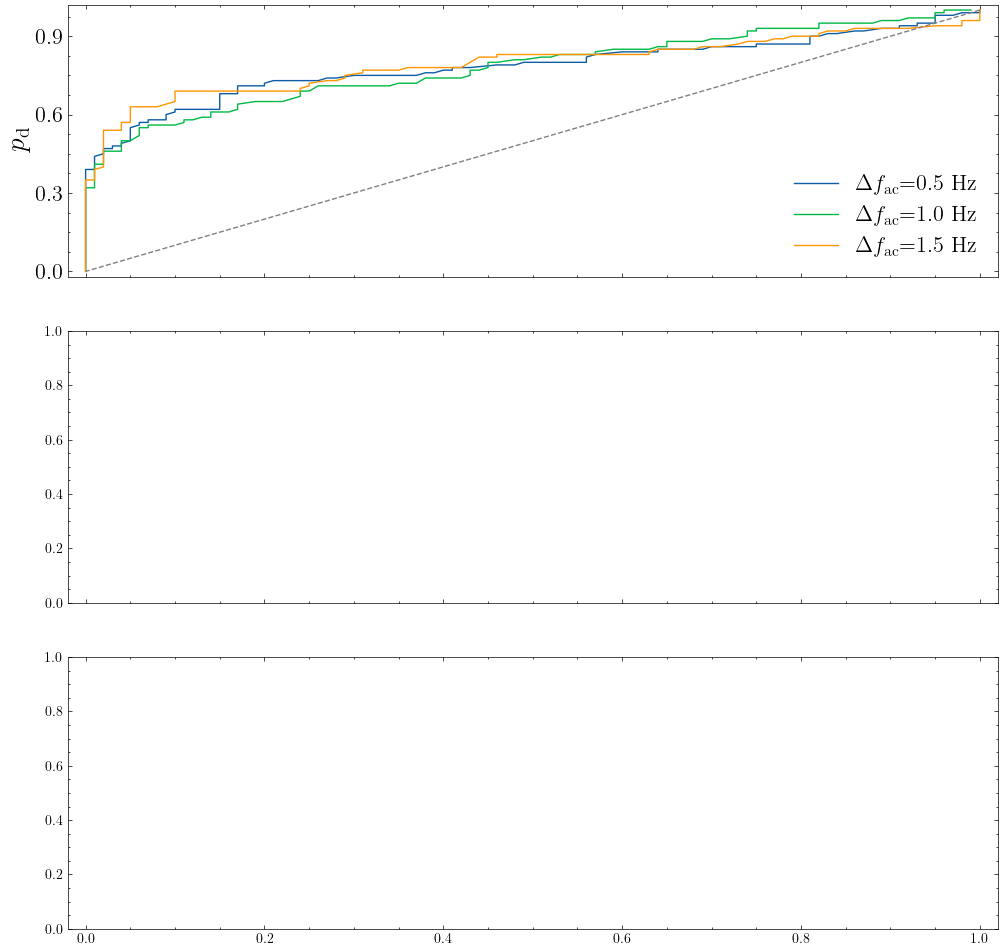

In [1]:
from scipy.io import loadmat
from matplotlib import pyplot as plt
import scienceplots
from scipy.interpolate import interp1d

plt.style.use('science')

root = '../../data/data_used_for_manuscript/'
identifiers = ['D_a','sigma_a','gamma_a']
files_to_plot = ['roc_case1_D_a_ver2.mat','roc_case2_sigma_a_ver2','roc_case3_gamma_a_ver2']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,12),sharex=True)
fs = 20

legend_label = [r'$\Delta f_{\rm ac}$',r'$\sigma_{\theta}^2$', r'$P$']
units = ['Hz', '', 's']
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])
def load_and_plot(path,ax,identifier,legend_title,unit):

    data = loadmat(path)

    pd = data["pd"] #shape (3,1001)
    pfa = data["pfa"].flatten() 
   
    pfa = pfa.reshape((pd.shape))

    labels = data[identifier].flatten()


    print(legend_title)
    for i in range(pd.shape[-1]):

        if legend_title == '$P$':
            labs = 1/labels[i] #i.e. for gamma
            labs = int(np.log10(labs))
            labs = fr'$10^{labs}$'
        else:
            labs = labels[i]


        if unit == '': #this is a bit clunky. Can't select on legend label
            labs = int(np.log10(labs))
            labs = fr'$10^{{{labs}}}$'


        ax.plot(pfa[:,i], pd[:,i], label = legend_title + '=' + str(labs) + ' ' + unit)
        f = interp1d(pfa[:,i], pd[:,i])
        pd_critical = f(0.05) #what is the 5% pd?
        print(identifier,labels[i],pd_critical)
    ax.plot(pfa[:,0],pfa[:,0],linestyle='dashed',c='0.5')

        

    #ax.legend(title=legend_title,fontsize=fs-4,title_fontsize=fs)
    ax.legend(fontsize=fs-4,loc='lower right')

    ax.set_ylabel(r"$p_{\rm d}$",fontsize=fs)
    ax.axes.tick_params(axis="both", labelsize=fs-4)
    delta = 0.02
    ax.set_xlim(0.0-delta,1.0+delta)
    ax.set_ylim(0.0-delta,1.0+delta)
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))


    #ax.set_xscale('log')




for i,f in enumerate(files_to_plot):
    load_and_plot(root+f,axes[i],identifiers[i],legend_label[i],units[i])



axes[-1].set_xlabel(r"$p_{\rm fa}$",fontsize=fs)

plt.subplots_adjust(hspace=0.0,wspace=0.0)
plt.savefig(f'../../data/images/roc_curve_mains_power_params',bbox_inches='tight',dpi=300)



['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']
$\Delta f_{\rm ac}$
D_a 0.5 0.5
D_a 1.0 0.5
D_a 1.5 0.57
$\sigma_{\theta}^2$
sigma_a 0.001 0.44
sigma_a 0.01 0.5
sigma_a 0.1 0.49
$P$
gamma_a 0.001 0.54
gamma_a 0.01 0.49
gamma_a 0.1 0.7


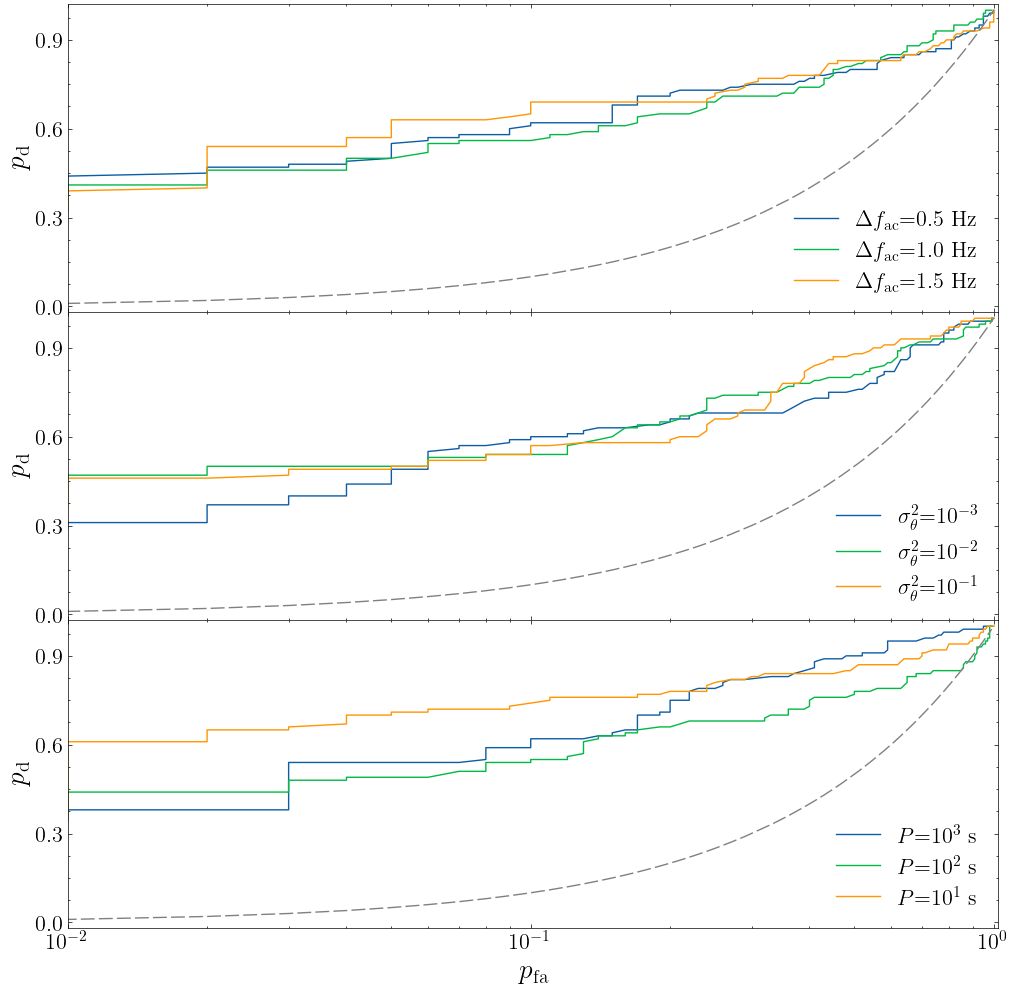

In [2]:
from scipy.io import loadmat
from matplotlib import pyplot as plt
import scienceplots
from scipy.interpolate import interp1d
import numpy as np 

plt.style.use('science')

root = '../../data/data_used_for_manuscript/'
identifiers = ['D_a','sigma_a','gamma_a']
files_to_plot = ['roc_case1_D_a_ver2.mat','roc_case2_sigma_a_ver2','roc_case3_gamma_a_ver2']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,12),sharex=True)
fs = 20

legend_label = [r'$\Delta f_{\rm ac}$',r'$\sigma_{\theta}^2$', r'$P$']
units = ['Hz', '', 's']
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])
def load_and_plot(path,ax,identifier,legend_title,unit):

    data = loadmat(path)

    pd = data["pd"] #shape (3,1001)
    pfa = data["pfa"].flatten() 
   
    pfa = pfa.reshape((pd.shape))

    labels = data[identifier].flatten()


    print(legend_title)
    for i in range(pd.shape[-1]):

        if legend_title == '$P$':
            labs = 1/labels[i] #i.e. for gamma
            labs = int(np.log10(labs))
            labs = fr'$10^{labs}$'
        else:
            labs = labels[i]


        if unit == '': #this is a bit clunky. Can't select on legend label
            labs = int(np.log10(labs))
            labs = fr'$10^{{{labs}}}$'


        ax.plot(pfa[:,i], pd[:,i], label = legend_title + '=' + str(labs) + ' ' + unit)
        f = interp1d(pfa[:,i], pd[:,i])
        pd_critical = f(0.05) #what is the 5% pd?
        print(identifier,labels[i],pd_critical)
    ax.plot(pfa[:,0],pfa[:,0],linestyle=(5,(10,3)),c='0.5') #https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html

        

    #ax.legend(title=legend_title,fontsize=fs-4,title_fontsize=fs)
    ax.legend(fontsize=fs-4,loc='lower right')

    ax.set_ylabel(r"$p_{\rm d}$",fontsize=fs)
    ax.axes.tick_params(axis="both", labelsize=fs-4)
    delta = 0.02
    #ax.set_xlim(0.0-delta,1.0+delta)
    ax.set_ylim(0.0-delta,1.0+delta)
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))


    ax.set_xscale('log')
    ax.set_xlim(1e-2,1.0+delta)





for i,f in enumerate(files_to_plot):
    load_and_plot(root+f,axes[i],identifiers[i],legend_label[i],units[i])



axes[-1].set_xlabel(r"$p_{\rm fa}$",fontsize=fs)

plt.subplots_adjust(hspace=0.0,wspace=0.0)
plt.savefig(f'../../data/images/roc_curve_mains_power_params',bbox_inches='tight',dpi=300)



# Section 5B 

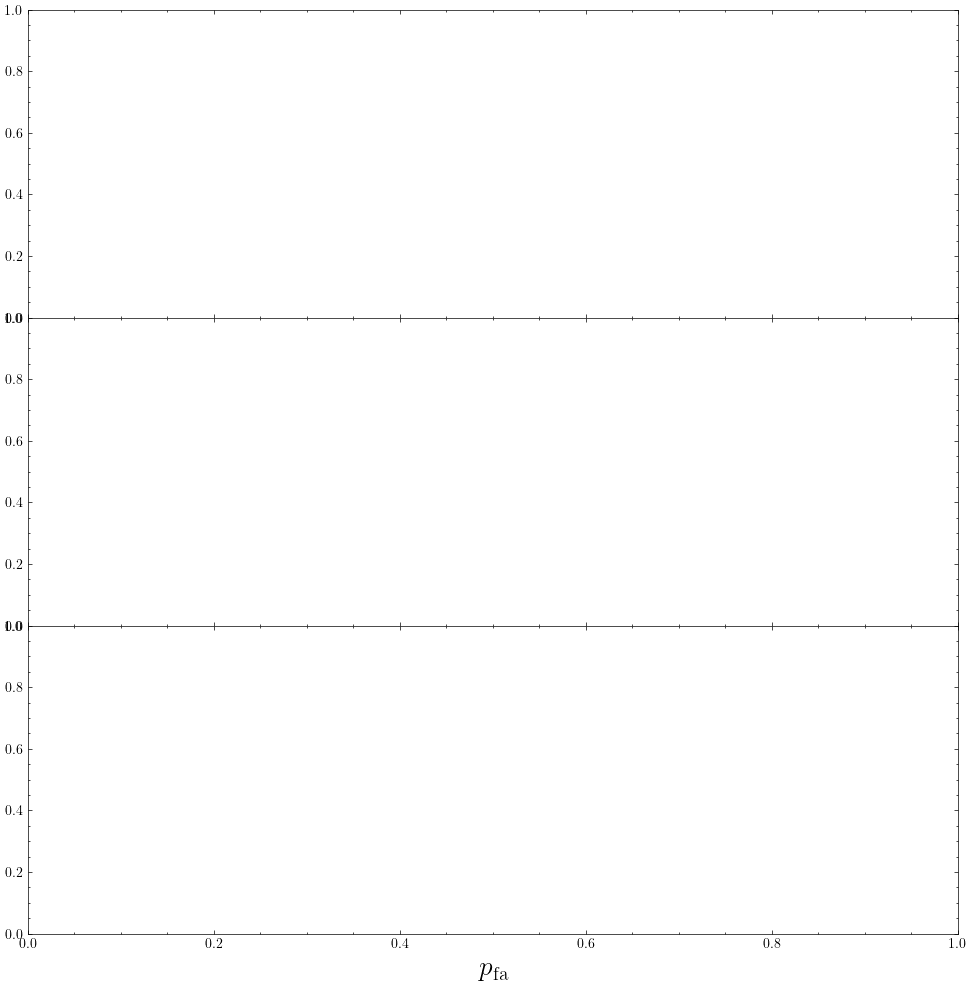

In [3]:
from scipy.io import loadmat
from matplotlib import pyplot as plt
import scienceplots
from scipy.interpolate import interp1d

plt.style.use('science')
root = '../../data/data_used_for_manuscript/'


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,12),sharex=True)
fs = 20







axes[-1].set_xlabel(r"$p_{\rm fa}$",fontsize=fs)
plt.subplots_adjust(hspace=0.0,wspace=0.0)
plt.savefig(f'../../data/images/roc_curve_mains_power_params',bbox_inches='tight',dpi=300)



Nref = 1 0.38
Nref = 2 0.52
Nref = 9 0.55
***The upper limit pd is = 0.85
M = 10 0.37
M = 15 0.57
M = 30 0.58
lambda = 0.9 0.02
lambda = 0.9999 0.51
lambda = 1.0 0.83


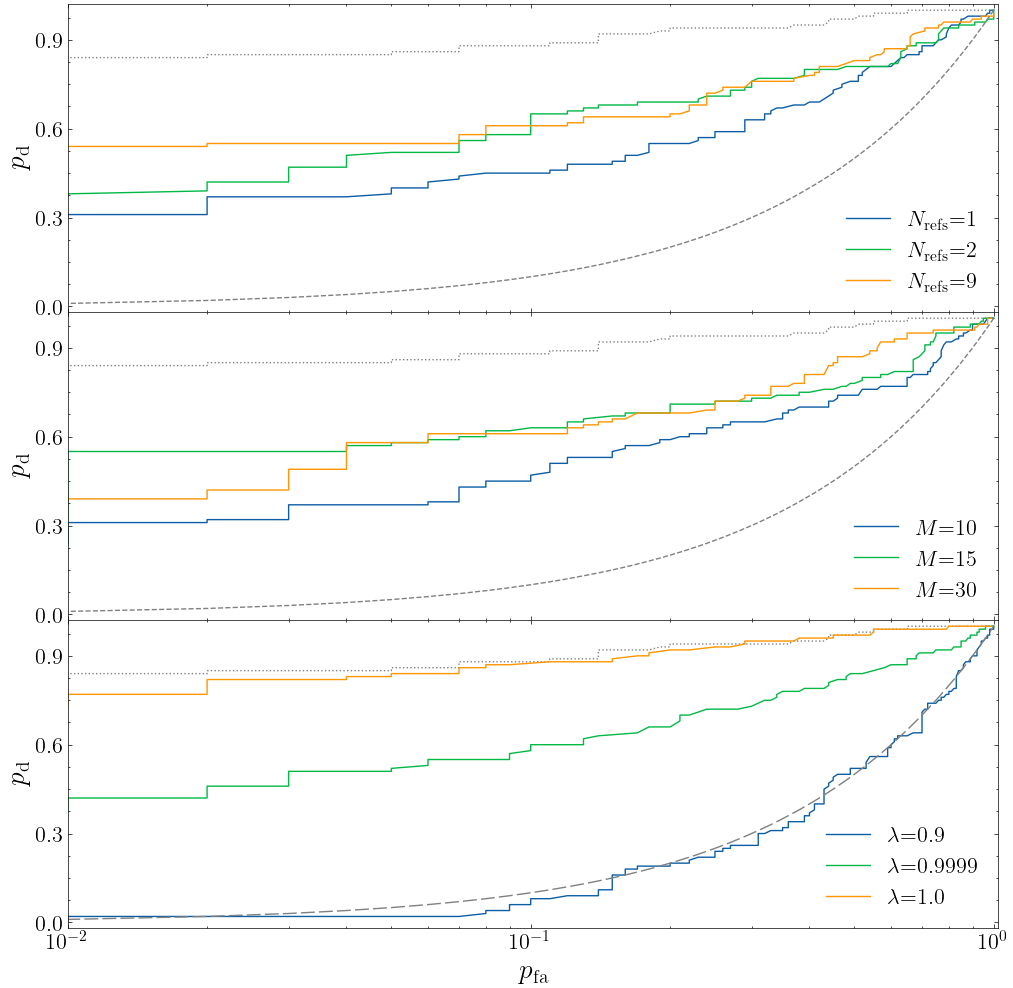

In [3]:
from scipy.io import loadmat
from matplotlib import pyplot as plt
import scienceplots
from scipy.interpolate import interp1d
import glob

plt.style.use('science')
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,12),sharex=True)

root = '../../data/data_used_for_manuscript/section5B/'



def grab_data(f):

     data = loadmat(f)
    
     pd = data["pd"] #shape (3,1001)
     pfa = data["pfa"].flatten() 
     pfa = pfa.reshape((pd.shape))

     return pfa, pd 

files_to_plot = glob.glob(root + '*')





#identifiers = ['D_a','sigma_a','gamma_a']
#files_to_plot = ['roc_case1_D_a_ver2.mat','roc_case2_sigma_a_ver2','roc_case3_gamma_a_ver2']


fs = 20


#Plot N ref on top axis
#This is all done maualy since data files are a bit tricky
f1 = '../../data/data_used_for_manuscript/section5B/roc_case1A_Nref.mat'


pfa,pd = grab_data(f1)
#Reload the data. Clunky
data_tmp = loadmat(f1)
labels = data_tmp["Nref"].flatten()

ax=axes[0]
for i in range(1,4):
    

    ax.plot(pfa[:,i], pd[:,i],label = r'$N_{\rm refs}$' + '=' + str(labels[i]))

    f = interp1d(pfa[:,i], pd[:,i])
    pd_critical = f(0.05) #what is the 5% pd?
        
    print('Nref =', labels[i], pd_critical)
  

#Also plot the 0 refs line
i = 0
upper_limit_pfa = pfa[:,i]
upper_limit_pd = pd[:,i]
for ax in axes:
    ax.plot(upper_limit_pfa, upper_limit_pd,c='0.5', linestyle = 'dotted')

f = interp1d(pfa[:,i], pd[:,i])
pd_critical = f(0.05) #what is the 5% pd?
print('***The upper limit pd is =', pd_critical)





ax=axes[0]
ax.plot(pfa[:,0],pfa[:,0],linestyle='dashed',c='0.5')
ax.legend(fontsize=fs-4,loc='lower right')
ax.set_ylabel(r"$p_{\rm d}$",fontsize=fs)
ax.axes.tick_params(axis="both", labelsize=fs-4)
delta = 0.02
#ax.set_xlim(0.0-delta,1.0+delta)
ax.set_ylim(0.0-delta,1.0+delta)
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.grid(False)
ax.set_xscale('log')
ax.set_xlim(1e-2,1.0+delta)
####
####
#Now plot M 






#f1 = '../../data/data_used_for_manuscript/section5B/roc_case_2A_M.mat'
f1 = '../../data/data_used_for_manuscript/section5B/roc_case2A_M_ver2.mat'


#roc_case2A_M_ver2

pfa,pd = grab_data(f1)
#Reload the data. Clunky
data_tmp = loadmat(f1)
#labels = ['15', '18', '25']
labels = ['10', '15', '30']

ax=axes[1]
for i in range(3):
    

    ax.plot(pfa[:,i], pd[:,i],label = r'$M$' + '=' + str(labels[i]))

    f = interp1d(pfa[:,i], pd[:,i])
    pd_critical = f(0.05) #what is the 5% pd?
        
    print('M =', labels[i], pd_critical)
  

ax.plot(pfa[:,0],pfa[:,0],linestyle='dashed',c='0.5')
ax.legend(fontsize=fs-4,loc='lower right')
ax.set_ylabel(r"$p_{\rm d}$",fontsize=fs)
ax.axes.tick_params(axis="both", labelsize=fs-4)
delta = 0.02
#ax.set_xlim(0.0-delta,1.0+delta)
ax.set_ylim(0.0-delta,1.0+delta)
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.grid(False)
ax.set_xscale('log')
ax.set_xlim(1e-2,1.0+delta)



####
####
#And now do lambda




f1 = '../../data/data_used_for_manuscript/section5B/roc_case_3A_lambda.mat'


pfa,pd = grab_data(f1)
#Reload the data. Clunky
data_tmp = loadmat(f1)
labels = data_tmp["lambda"].flatten()

ax=axes[2]
for i in range(3):
    

    ax.plot(pfa[:,i], pd[:,i],label = r'$\lambda$' + '=' + str(labels[i]))

    f = interp1d(pfa[:,i], pd[:,i])
    pd_critical = f(0.05) #what is the 5% pd?
        
    print('lambda =', labels[i], pd_critical)
  

ax.plot(pfa[:,0],pfa[:,0],linestyle=(5,(10,3)),c='0.5')
ax.legend(fontsize=fs-4,loc='lower right')
ax.set_ylabel(r"$p_{\rm d}$",fontsize=fs)
ax.axes.tick_params(axis="both", labelsize=fs-4)
delta = 0.02
#ax.set_xlim(0.0-delta,1.0+delta)
ax.set_ylim(0.0-delta,1.0+delta)
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.grid(False)

ax.set_xscale('log')
ax.set_xlim(1e-2,1.0+delta)
    

axes[-1].set_xlabel(r"$p_{\rm fa}$",fontsize=fs)
plt.subplots_adjust(hspace=0.0,wspace=0.0)
plt.savefig(f'../../data/images/roc_curve_filter_params',bbox_inches='tight',dpi=300)



These are the data files:

In [20]:
for f in files_to_plot:
    print(f)
    data = loadmat(f)
    print(data.keys())
    print(data['pd'].shape)
    print(data['pfa'].shape)
    print(data)
    print('-----------------')


../../data/data_used_for_manuscript/section5B/roc_case1A_Nref.mat
dict_keys(['__header__', '__version__', '__globals__', 'Nref', 'pd', 'pfa', 'sth'])
(1001, 4)
(1001, 4)
{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Oct  2 15:46:43 2023', '__version__': '1.0', '__globals__': [], 'Nref': array([[0, 1, 2, 9]], dtype=uint8), 'pd': array([[1.  , 1.  , 1.  , 0.99],
       [1.  , 1.  , 1.  , 0.99],
       [1.  , 1.  , 0.99, 0.99],
       ...,
       [0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  ]]), 'pfa': array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), 'sth': array([[ 927.14054189,  833.43548961,  873.01260901, ...,
         980.68010317,  800.23726866, 1025.78987491]])}
-----------------
../../data/data_used_for_manuscript/section5B/roc_case_2A_M.mat
dict_keys(['__header__', '__version__', '__globals__', 'p

# Section 4C

In this section we vary the power line parameters, for a single reference channel, and generate some ROC curves 

$ \Delta f = 0.0 \, , \gamma = 0.001$ Computed AUC using sklearn.metrics.auc: 0.67765
$\Delta f = 0.0 \, ,  \gamma = 0.01$ Computed AUC using sklearn.metrics.auc: 0.65315
$ \Delta f = 0.0 \, , \gamma = 0.1$ Computed AUC using sklearn.metrics.auc: 0.5529499999999999
$ \gamma = 0.02 \, , \Delta f = 0.25$ Computed AUC using sklearn.metrics.auc: 0.6231000000000001
$ \gamma = 0.02 \, ,  \Delta f = 0.5$ Computed AUC using sklearn.metrics.auc: 0.5787
$ \gamma = 0.02 \, , \Delta f = 1.0$ Computed AUC using sklearn.metrics.auc: 0.58465


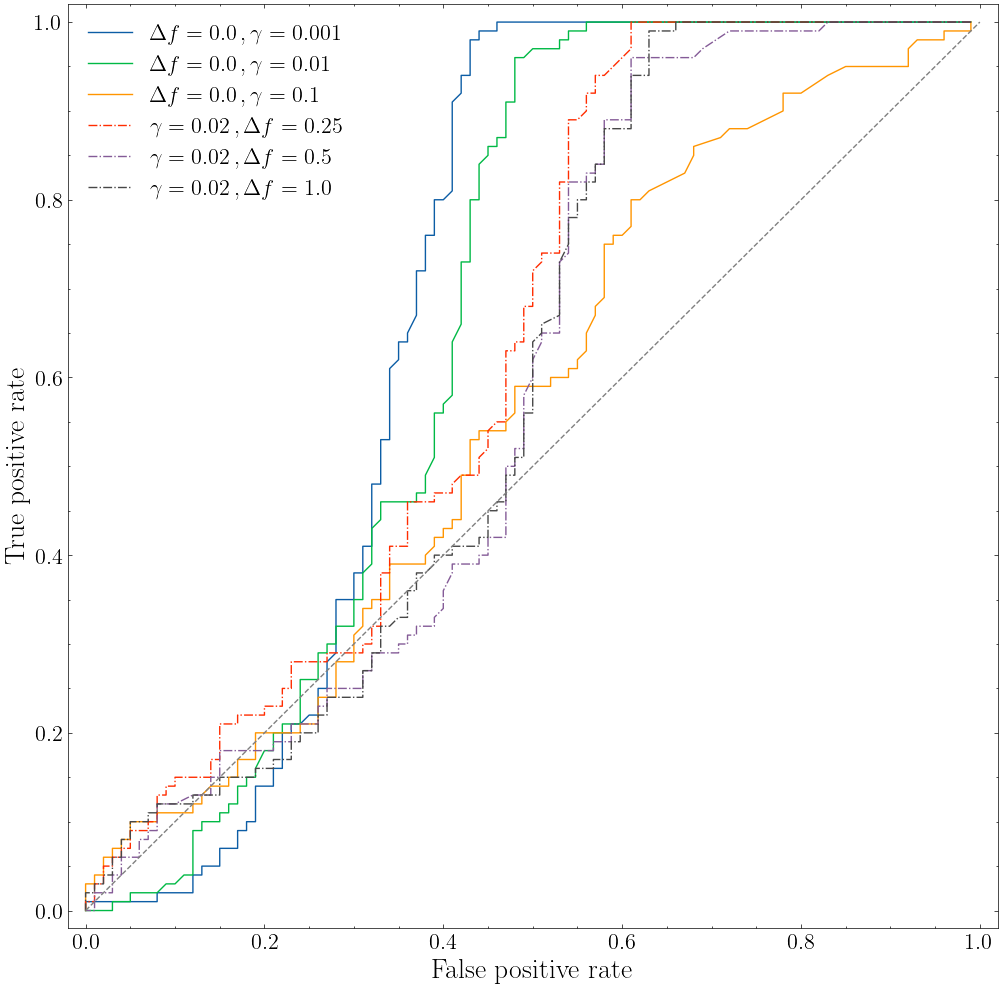

In [243]:

from scipy.io import loadmat
import numpy as np 


from matplotlib import pyplot as plt
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob 
import sys
from sklearn.metrics import auc

plt.style.use('science')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),sharex=False)




path1 = "../../data/roc_sec4_1.mat"
path2 = "../../data/roc_sec4_2.mat"

labels1 = [r'$ \Delta f = 0.0 \, , \gamma = 0.001$', r'$\Delta f = 0.0 \, ,  \gamma = 0.01$',r'$ \Delta f = 0.0 \, , \gamma = 0.1$']
labels2 = [r'$ \gamma = 0.02 \, , \Delta f = 0.25$',r'$ \gamma = 0.02 \, ,  \Delta f = 0.5$',r'$ \gamma = 0.02 \, , \Delta f = 1.0$' ]


def load_and_plot(path,ax,labels,ls):


   

    data = loadmat(path)


    pd = data["pd"] #shape (3,1001)
    pfa = data["pfa"].flatten() #shape (1,1001)

    for i in range(len(pd)):
        ax.plot(pfa, pd[i,:], label = labels[i],linestyle=ls)

        #Also get the AUC e.g. https://link.springer.com/referenceworkentry/10.1007/978-1-4419-9863-7_209

        print(labels[i], 'Computed AUC using sklearn.metrics.auc: {}'.format(auc(pfa,pd[i,:])))


load_and_plot(path1,ax=ax,labels=labels1,ls='solid') #this is ∆f = 0.0 with γ = {0.001, 0.01, 0.1} for 1 reference PEM
load_and_plot(path2,ax=ax,labels=labels2,ls='dashdot') #thi is γ = 0.02  and ∆f = {0.25, 0.5, 1.0} for 1 reference PEM



fs = 20
ax.set_xlabel("False positive rate",fontsize=fs)
ax.set_ylabel("True positive rate",fontsize=fs)
ax.axes.tick_params(axis="both", labelsize=fs-4)

ax.legend(fontsize=fs-4)

delta = 0.02
ax.set_xlim(0.0-delta,1.0+delta)
ax.set_ylim(0.0-delta,1.0+delta)


x = np.linspace(0,1,100)
ax.plot(x,x,linestyle='--',c='0.5')

fname = '4C_roccurve' 
if fname is not None:
    plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)

plt.show()






We can also plot them on separate axes if preferred...

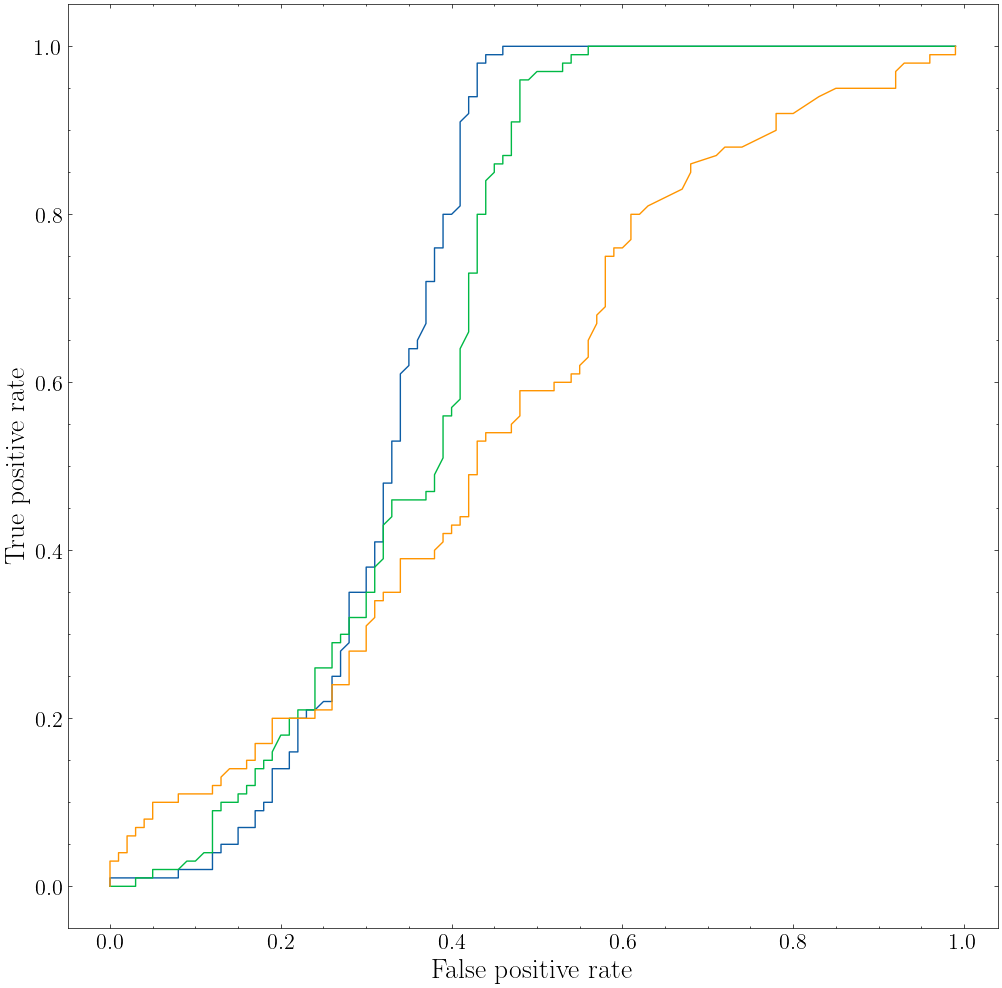

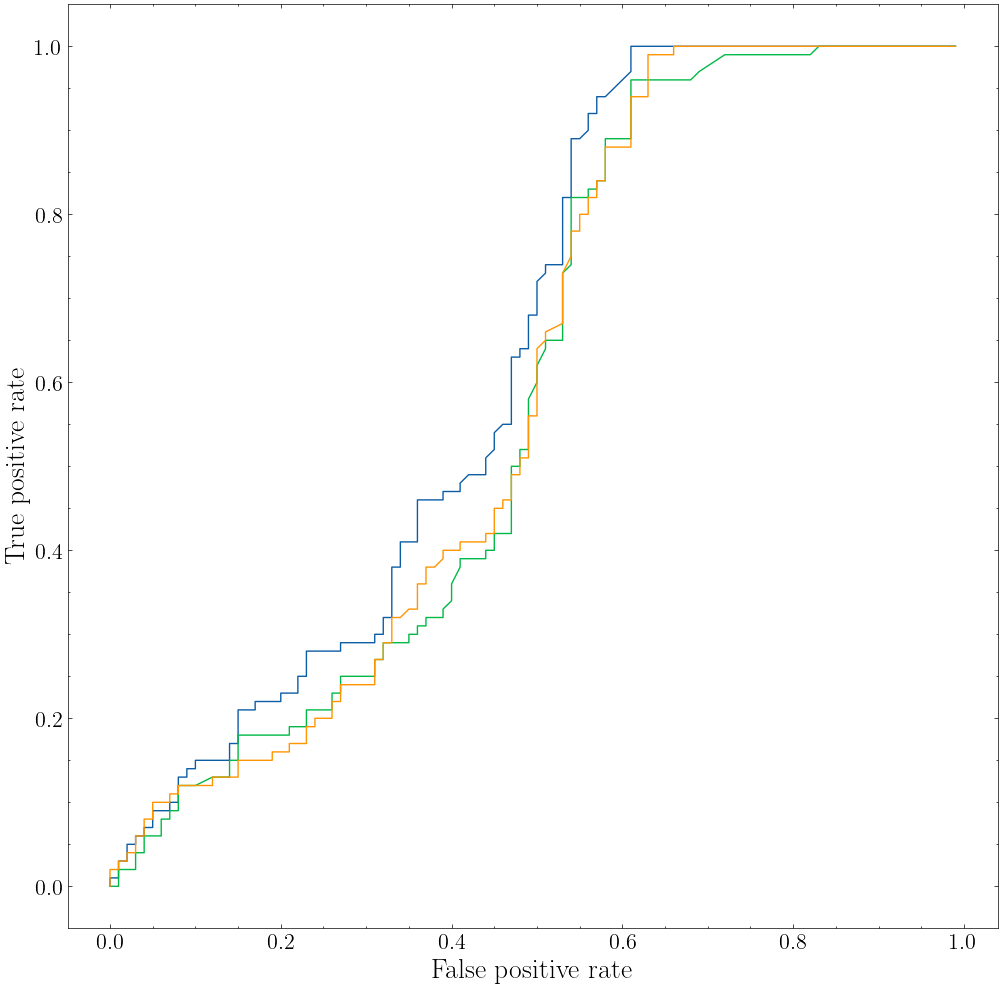

In [89]:
from scipy.io import loadmat
import numpy as np 


from matplotlib import pyplot as plt
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys

plt.style.use('science')







path1 = "../../data/roc_sec4_1.mat"
path2 = "../../data/roc_sec4_2.mat"

import glob 





def load_and_plot(path,fname=None):


    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),sharex=False)

    data = loadmat(path)


    pd = data["pd"] #shape (3,1001)
    pfa = data["pfa"].flatten() #shape (1,1001)



    labels = [r'$\gamma = 0.001$', r'$\gamma = 0.01$',r'$\gamma = 0.1$']
    for i in range(len(pd)):
        ax.plot(pfa, pd[i,:], label = labels[i])




    fs = 20
    ax.set_xlabel("False positive rate",fontsize=fs)
    ax.set_ylabel("True positive rate",fontsize=fs)
    ax.axes.tick_params(axis="both", labelsize=fs-4)


   
    if fname is not None:
        plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)

    plt.show()
        



    
load_and_plot(path1,fname='example_powerline_roc_curve_1') #this is ∆f = 0.0 with γ = {0.001, 0.01, 0.1} for 1 reference PEM
load_and_plot(path2,fname='example_powerline_roc_curve_2') #thi is γ = 0.02  and ∆f = {0.25, 0.5, 1.0} for 1 reference PEM






# Section 4D



pd_h_002_gammah_0001_df_0_ref_1
pd_h_002_gammah_0001_df_0_ref_2
pd_h_002_gammah_001_df_0_ref_1
pd_h_002_gammah_001_df_0_ref_2
pd_h_002_gammah_001_df_05_ref_1
pd_h_002_gammah_001_df_05_ref_2
-----------------------
pd_h_002_gammah_0001_df_0_ref_1
$\gamma = 10^{-3} \, , \Delta f = 0.0 \, , N_{\rm refs} = 1$ AUC: 0.97545
pd_h_002_gammah_0001_df_0_ref_2
$\gamma = 10^{-3} \, , \Delta f = 0.0 \, , N_{\rm refs} = 2$ AUC: 0.9901499999999999
pd_h_002_gammah_001_df_0_ref_1
$\gamma = 10^{-2} \, , \Delta f = 0.0 \, , N_{\rm refs} = 1$ AUC: 0.8265999999999999
pd_h_002_gammah_001_df_0_ref_2
$\gamma = 10^{-2} \, , \Delta f = 0.0 \, , N_{\rm refs} = 2$ AUC: 0.8221499999999999
pd_h_002_gammah_001_df_05_ref_1
$\gamma = 10^{-2} \, , \Delta f = 0.5 \, , N_{\rm refs} = 1$ AUC: 0.9873000000000001
pd_h_002_gammah_001_df_05_ref_2
$\gamma = 10^{-2} \, , \Delta f = 0.5 \, , N_{\rm refs} = 2$ AUC: 0.9899999999999999
Reference AUC: 0.5450314017192998


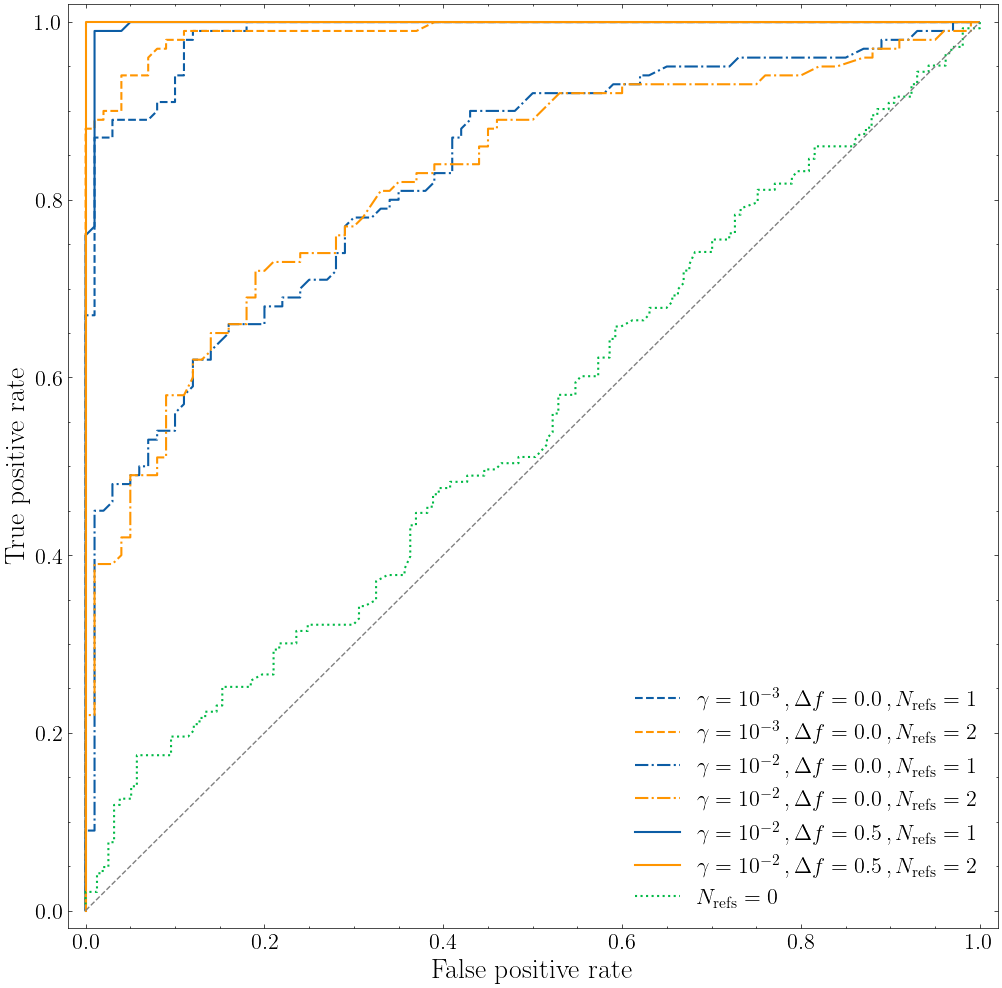

In [230]:
from scipy.io import loadmat
import numpy as np 
from matplotlib import pyplot as plt
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob 

plt.style.use('science')
path = "../../data/roc_curves_final.mat"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),sharex=False)




def parse_number_string(fname):
    num_leading_zeros = len(fname.split('1')[0]) - 1 
    val = float(fname) / 10**num_leading_zeros
    return val


def parse_keyname(key):

    row = key.split('_')

    h = row[2]
    gamma = parse_number_string(row[4])
    delta_f = parse_number_string(row[6])
    num_refs = row[-1] #'PEM = 0'
    if num_refs == 'PEM':
        num_refs = 0.0
    num_refs = int(num_refs)
  
    return h,np.log10(gamma)-1,delta_f,num_refs




def load_and_plot(path,ax):


    data = loadmat(path)

    excluded_keys = ['pd_PEM', 'pfa_PEM'] #These are the nothing results i.e. coin toss. e.g. https://app.sparkmailapp.com/web-share/XPIkC9jW8wiCL5Z3Cab9lV562ZIYm1y_PPhc1ZGw
    #excluded_keys = []
    list_of_keys = sorted([k for k in data.keys() if (k.startswith('p') & (k not in excluded_keys)& ~(k.endswith('M')))])
    
    l = len(list_of_keys)

    pd_keys = list_of_keys[0:int(l/2)]
    pfa_keys = list_of_keys[int(l/2):]
    colors = ['C0','C1','C2']
    colors = ['C0','C2']

    linestyles = ['dashed','dashdot','solid']
    color_index = 0
    line_index = 0


    #Some hacky slicing to put df=0.5 at the end
    pd_keys = pd_keys[0:2] + pd_keys[4:6] + pd_keys[2:4]
    pfa_keys = pfa_keys[0:2] + pfa_keys[4:6] + pfa_keys[2:4]

    for kk in pd_keys:
        print(kk)
    print('-----------------------')

    for k in range(len(pd_keys)):
        assert parse_keyname(pd_keys[k]) == parse_keyname(pfa_keys[k])
        h,gamma,delta_f,num_refs = parse_keyname(pd_keys[k])
        print(pd_keys[k])

        #label = [r'$\gamma = 0.001 \, , \Delta f = 0.0 \ , N_{\rm refs} = 0$']

        gamma = int(gamma)
        label = fr'$\gamma = 10^{{{gamma}}} \, , \Delta f = {delta_f} \, , N_{{\rm refs}} = {num_refs}$'

        pfa_key, pd_key = pfa_keys[k], pd_keys[k]

    
        ax.plot(data[pfa_key].flatten(),data[pd_key].flatten(),lw=1.5,label=label,c=colors[color_index],linestyle=linestyles[line_index])

        print(label, 'AUC: {}'.format(auc(data[pfa_key].flatten(),data[pd_key].flatten())))
        
        color_index += 1

        if color_index > 1:
            color_index = 0
            line_index +=1



    
    ax.plot(data['pfa_PEM'].flatten(),data['pd_PEM'].flatten(),lw=1.5,linestyle='dotted',c='C1',label=r'$N_{\rm refs} =0$')
    print('Reference', 'AUC: {}'.format(auc(data['pfa_PEM'].flatten(),data['pd_PEM'].flatten())))


    
load_and_plot(path,ax)




fs = 20
ax.set_xlabel("False positive rate",fontsize=fs)
ax.set_ylabel("True positive rate",fontsize=fs)
ax.axes.tick_params(axis="both", labelsize=fs-4)

ax.legend(fontsize=fs-4)



delta = 0.02
ax.set_xlim(0.0-delta,1.0+delta)
ax.set_ylim(0.0-delta,1.0+delta)


#ax.set_xscale('log')
#ax.set_xlim(1e-3,1.0)


x = np.linspace(0,1,100)
ax.plot(x,x,linestyle='--',c='0.5')

fname = '4C_roccurve_multi_ref' 
if fname is not None:
    plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)

plt.show()



Plot just one the diagonal result

pd_h_002_gammah_0001_df_0_NO_PEM
pd_h_002_gammah_0001_df_0_ref_1
pd_h_002_gammah_0001_df_0_ref_2


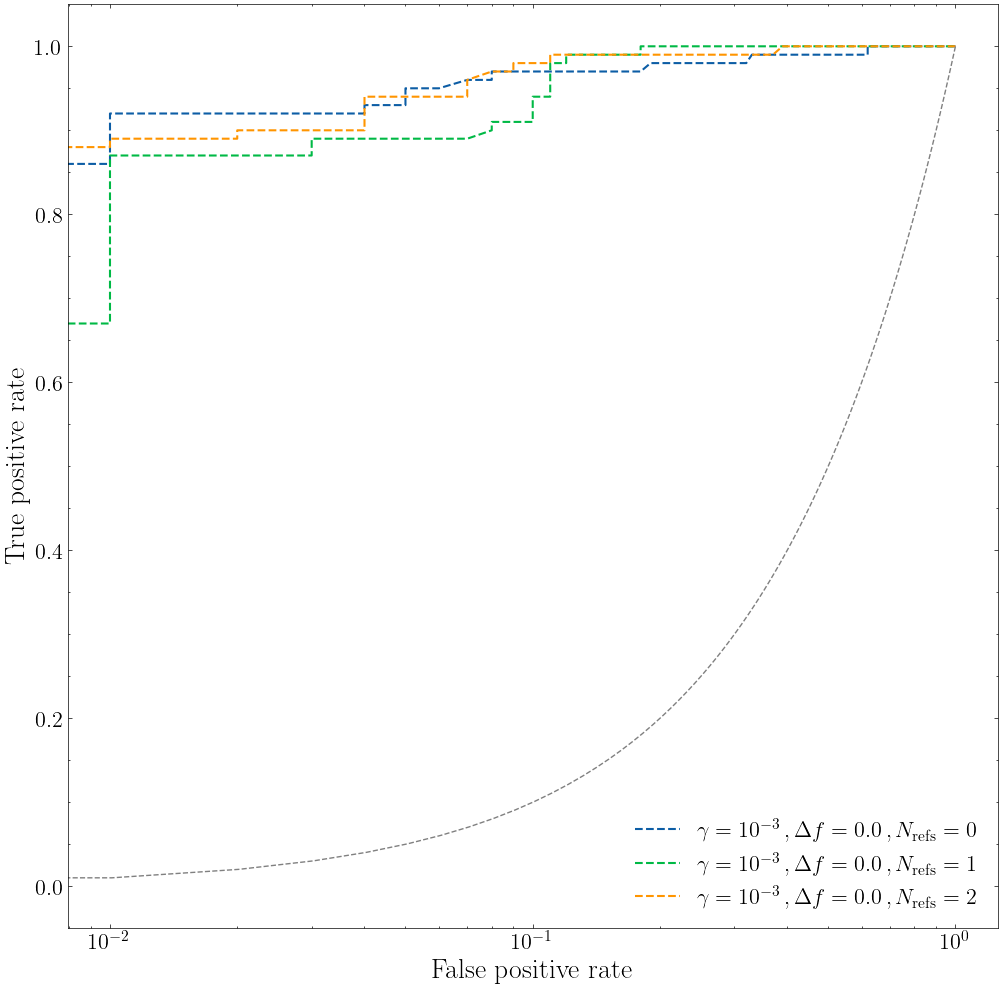

In [198]:
from scipy.io import loadmat
import numpy as np 
from matplotlib import pyplot as plt
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob 

plt.style.use('science')
path = "../../data/roc_curves_final.mat"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),sharex=False)

            


def parse_number_string(fname):
    num_leading_zeros = len(fname.split('1')[0]) - 1 
    val = float(fname) / 10**num_leading_zeros
    return val


def parse_keyname(key):

    row = key.split('_')

    h = row[2]
    gamma = parse_number_string(row[4])
    delta_f = parse_number_string(row[6])
    num_refs = row[-1] #'PEM = 0'
    if num_refs == 'PEM':
        num_refs = 0.0
    num_refs = int(num_refs)
  
    return h,np.log10(gamma)-1,delta_f,num_refs




def load_and_plot(path,ax):


    data = loadmat(path)

    excluded_keys = ['pd_PEM', 'pfa_PEM'] #These are the nothing results i.e. coin toss. e.g. https://app.sparkmailapp.com/web-share/XPIkC9jW8wiCL5Z3Cab9lV562ZIYm1y_PPhc1ZGw
    list_of_keys = sorted([k for k in data.keys() if (k.startswith('p') & (k not in excluded_keys))])
    
    
     

    
    ax.plot(data['pfa_PEM'].flatten(),data['pd_PEM'].flatten(),lw=1.5,label=label,c=colors[color_index],linestyle=linestyles[line_index])
     


    
load_and_plot(path,ax)




fs = 20
ax.set_xlabel("False positive rate",fontsize=fs)
ax.set_ylabel("True positive rate",fontsize=fs)
ax.axes.tick_params(axis="both", labelsize=fs-4)

ax.legend(fontsize=fs-4)



#delta = 0.05
#ax.set_xlim(0.0-delta,1.0+delta)
#ax.set_ylim(0.0-delta,1.0+delta)


x = np.linspace(0,1,100)
ax.plot(x,x,linestyle='--',c='0.5')

plt.show()



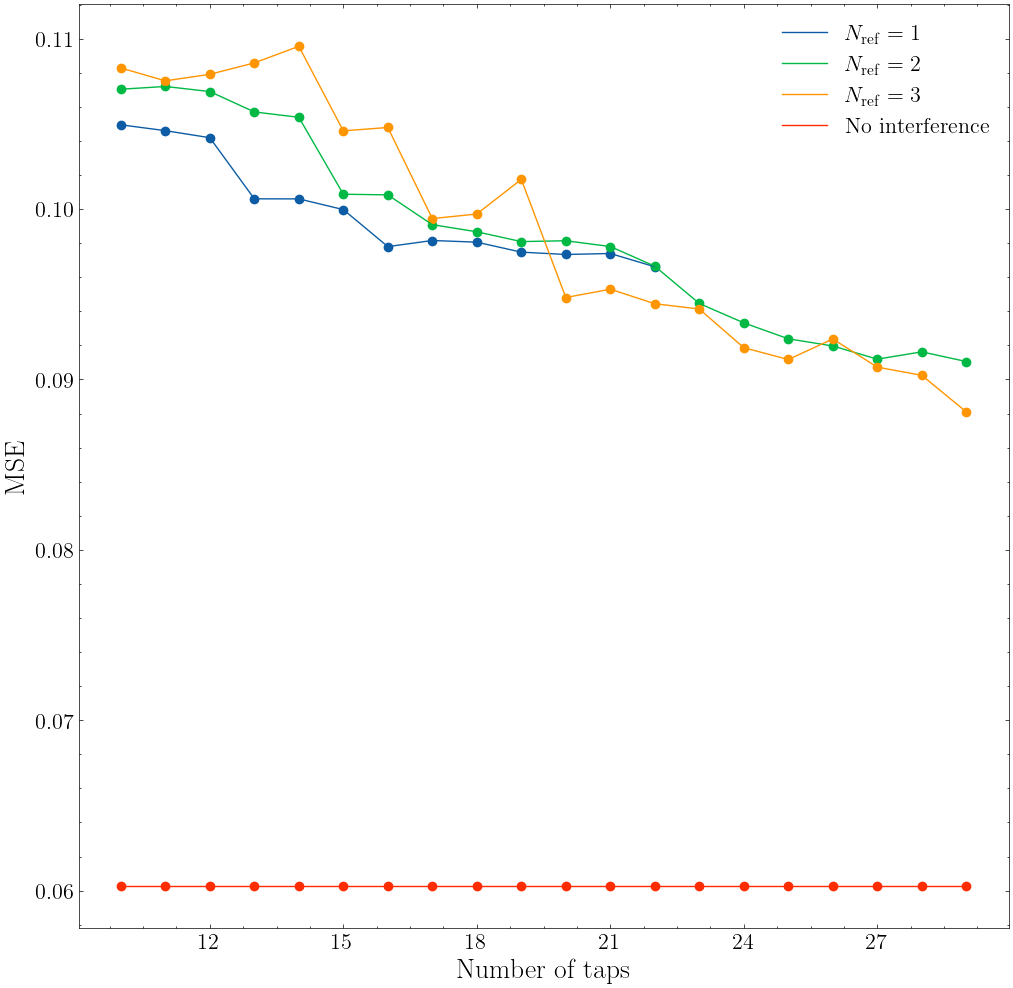

In [242]:
from scipy.io import loadmat
import numpy as np 
from matplotlib.ticker import MaxNLocator

import matplotlib.pyplot as plt 

path = "../../data/filter_accuraacy.mat"

data = loadmat(path)
LL = data["LL"]
dw = data["dw"]
gamma = data["gamma"]
gamma_a = data["gamma_a"]
h = data["h"]



#Plot figure
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,12))

labels = [r'$N_{\rm ref} = 1$', r'$N_{\rm ref} = 2$', r'$N_{\rm ref} = 3$', 'No interference']
for i in range(4):
    y = LL[i,:]
    x = np.arange(len(y))

    ax1.plot(x,y,label=labels[i])
    ax1.scatter(x,y)




fs = 20
ax1.set_ylabel(r'MSE',fontsize=fs)
ax1.set_xlabel(r'Number of taps',fontsize=fs)
ax1.axes.tick_params(axis="both", labelsize=fs-4)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.legend(fontsize=fs-4)
  
fname = "taps_vs_error"
plt.savefig(f'../../data/images/{fname}',bbox_inches='tight',dpi=300)

plt.show()


# Additional calculations


## What is $\sigma_f T_{\rm obs}^{1/2} / f_{\rm ac}$?

In [106]:

sigma_f_2 = 0.01
sigma_f = np.sqrt(sigma_f_2)
Tobs = 800
fac = 60

print (sigma_f*np.sqrt(Tobs)/fac)

0.047140452079103175


In [107]:

sigma_f_2 = 0.1
sigma_f = np.sqrt(sigma_f_2)
Tobs = 800
fac = 60

print (sigma_f*np.sqrt(Tobs)/fac)

0.14907119849998599
